In [12]:
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40))
import openslide
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import xml.etree.cElementTree as ET
from tqdm import tqdm
import openslide

In [21]:
json_path = '/work/u3516703/work/VeinDatasetV3/inference_json/20-00002-Masson.geojson'
wsi_path = '/work/u3516703/work/evaluation_dataset/wsi_path/20-00002-Masson.mrxs'
xml_path = '/work/u3516703/work/evaluation_ver2/wsi_pred/20-00002-Masson.xml'

In [2]:
def read_bbox_from_json(file_path):
    """
    讀取 Bounding-Box 的 geojson 
    """
    Json = []
    import json
    with open(file_path) as f:
        datas = json.load(f)
        for data in datas:
            box = {
                "class":data["properties"]["classification"]["name"],
                "coordinates":data["geometry"]["coordinates"][0][:4]
                  }
            Json.append(box)
    return Json

In [14]:
def extract_annotation(line):
    """Extract the annotation details from the given line."""
    parts = line.split('"')
    name = parts[1]
    annotation_type = parts[3]
    part_of_group = parts[5]
    
    # Map partOfGroup to meaningful names
    annotation = {
        'name': 'fibrosis' if part_of_group == '0' else 'lumen',
        'partOfGroup': 'fibrosis',
        'type': annotation_type.lower()
    }
    
    return annotation

def extract_coordinates(line):
    """Extract coordinates from the given line."""
    parts = line.split('"')
    x = float(parts[3])
    y = float(parts[5])
    return [x, y]
    
def read_fibrosis_xml(xml_path):
    """
    讀取 Fibrosis XML 檔案，回傳 json
    """
    json_datas = {'annotation': []}
    
    with open(xml_path, 'r') as xml_file:
        annotation = None
        coordinates = []

        for line in xml_file:
            if 'Annotation Name' in line:
                annotation = extract_annotation(line)
                coordinates = []
            elif 'Coordinate Order' in line:
                coordinate = extract_coordinates(line)
                coordinates.append(coordinate)
            elif '/Coordinates' in line and annotation is not None:
                annotation['coordinates'] = coordinates
                json_datas['annotation'].append(annotation)
                annotation = None 
    return json_datas

In [24]:
def parse_json(json_datas):
    """
    將 Fibrosis jsondatas 分成 fibrosis 和 lumen (內圈)
    """
    contours = json_datas['annotation']
    fibrosis_contours=[]
    lumen_contours=[]
    for contour in contours:
        if contour['name']=='fibrosis':
            fibrosis_contours.append(contour)
        elif contour['name']=='lumen':
            lumen_contours.append(contour)
        else:
            pass
    return fibrosis_contours,lumen_contours

def generate_fibrosis_mask(wsi_path,xml_path,level=3):
    """
    讀取 Fibrosis xml 檔案，回傳 mask (GrayScale)
    """
    scale_rate = 2 ** level
    classes = {'duct':0 ,'portal':1, 'central':2}
    colors = [(255,0,0),(0,255,0),(0,0,255)]
    
    # 1. Get Image Shape & Generate Mask
    wsi_data = openslide.OpenSlide(wsi_path)
    width, height = wsi_data.level_dimensions[level]
    mask = np.zeros((height, width), np.uint8)

    # 2. Read BBox Json
    json_datas = read_fibrosis_xml(xml_path)
    fibrosis_contours,lumen_contours = parse_json(json_datas)


    for contour in fibrosis_contours:
        coordinates = contour['coordinates']
        coordinates = [[int(value / scale_rate) for value in coordinate] for coordinate in coordinates]
        coordinates = np.array([coordinates], dtype=np.int32)
        mask = cv2.fillPoly(mask, coordinates, 255)
    for contour in lumen_contours:
        coordinates = contour['coordinates']
        coordinates = [[int(value / scale_rate) for value in coordinate] for coordinate in coordinates]
        coordinates = np.array([coordinates], dtype=np.int32)
        mask = cv2.fillPoly(mask, coordinates, 0)
    return mask

In [93]:
def generate_bbox_mask(wsi_path,json_path,level=3):
    """
    讀取 bbox geojson，回傳 bbox mask (BGR)
    """
    scale_rate = 2 ** level
    classes = {'duct':0 ,'portal':1, 'central':2}
    colors = [(255,0,0),(0,255,0),(0,0,255)]
    
    # 1. Get Image Shape & Generate Mask
    wsi_data = openslide.OpenSlide(wsi_path)
    width, height = wsi_data.level_dimensions[level]
    mask = np.zeros((height, width, 3), np.uint8)

    # 2. Read BBox Json
    json_datas = read_bbox_from_json(json_path)

    # 3. Draw JsonDatas on Mask
    for json_data in json_datas:
        bbox_class = json_data['class']
        class_idx = classes[bbox_class]
        coordinates = []
        coordinates.append(json_data['coordinates'][0])
        coordinates.append(json_data['coordinates'][2])
        coordinates = [[round(coordinate[0]/scale_rate),round(coordinate[1]/scale_rate)] for coordinate in coordinates]
        
        x1, y1 = coordinates[0] 
        x2, y2 = coordinates[1]
        cv2.rectangle(mask, (x1, y1), (x2, y2), colors[class_idx], -1)
    return mask

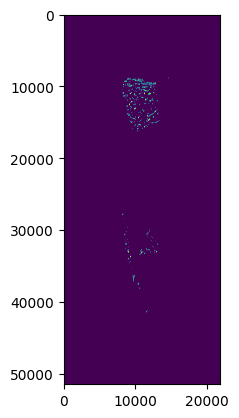

In [23]:
mask = generate_fibrosis_mask(wsi_path,xml_path,level=3)
plt.imshow(mask)
plt.show()